# Testing software

In [61]:
import numpy as np
from matplotlib import pyplot as plt
import os
import stan_utility

## Sources

Decided to go with the astromodels package as python3 branch is working well.

To install: 
```
pip install git+https://github.com/giacomov/astromodels.git@py2to3
```

In [62]:
from python.source.source import *
from astromodels.functions.functions import Powerlaw
from astromodels import Model

In [63]:
# Single source
source = PointSource('point', ra=0.0, dec=0.0, redshift=0.1, unit_vector = [1, 0, 0], spectral_shape=Powerlaw())
source.position.get_ra()
source.redshift

0.1

In [64]:
#source_list = ManualSourceList([source])
#zth = 1
#diffuse_bg = DiffuseSource('diffuse_bg', zth, spectral_shape=Powerlaw())
#source_list.add(diffuse_bg)

In [65]:
# Loading from file
source_file = '../dev/statistical_model/data/test_SFR_pop.h5'
source_list = TestSourceList(source_file, spectral_shape=Powerlaw())

# Select sources below zth = 1
zth = 1
source_list.select_below_redshift(zth)

# Add a diffuse background at z = 1
diffuse_bg = DiffuseSource('diffuse_bg', zth, spectral_shape=Powerlaw())
source_list.add(diffuse_bg)

In [66]:
source_list.N

38

In [67]:
source_list.sources[0].redshift

0.6818505255578298

In [68]:
source_list.sources[0].position.dec

Parameter dec = -19.438230205811653 [deg]
(min_value = -90.0, max_value = 90.0, delta = 1.9438230205811653, free = False)

In [69]:
# Could also use an astromodels model
source_model = Model(*source_list.sources)

## Precomputation

In [70]:
from python.Precomputation import ExposureIntegral
from python.detector_model import NorthernTracksEffectiveArea

In [71]:
time = 8 # years -> not used rn
Emin = 1.0e5 # GeV

exposure_integral = ExposureIntegral(source_list, NorthernTracksEffectiveArea, 
                                     time, Emin)
exposure_integral()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11c912550> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11aae69d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11c2cf7d0> already on stack


/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


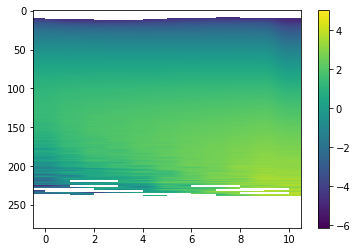

In [72]:
fig, ax = plt.subplots()
plt.imshow(np.log10(exposure_integral._effective_area._eff_area), aspect='auto')
plt.colorbar()

In [73]:
np.shape(exposure_integral._effective_area._eff_area)
exposure_integral._effective_area._cosz_bin_edges

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1])

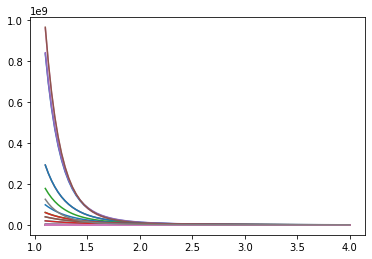

In [74]:
fig, ax = plt.subplots()
for _ in exposure_integral.integral_grid:
    ax.plot(exposure_integral.alpha_grid, _)

## Generate Stan code for simulation


In [75]:
from python.detector_model import NorthernTracksDetectorModel
from python.backend.stan_generator import (
    StanGenerator, GeneratedQuantitiesContext, DataContext, TransformedDataContext,
    FunctionsContext, Include, ForLoopContext, StanFileGenerator, WhileLoopContext)
from python.backend.variable_definitions import ForwardVariableDef, ForwardArrayDef
from python.backend.expression import StringExpression
from python.backend.parameterizations import DistributionMode
import logging
logging.basicConfig(level=logging.WARN)

In [76]:
with StanFileGenerator("stan_files/detector_model_test") as cg:   
    ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
    ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
    cg.generate_files()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11c89ca50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11c921190> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11c9212d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11c921350> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11c9210d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11c921250> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11c921a50> already on stack
INFO:python.backend.code_gener

In [91]:
with StanFileGenerator("stan_files/sim_code") as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("sim_functions.stan")
        _ = Include("energy_spectrum.stan")
            
    with DataContext() as dc:
        
        # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        D = ForwardVariableDef("D", "vector[Ns]")
        redshift = ForwardVariableDef("z", "vector[Ns+1]")
        
        # Energies
        alpha = ForwardVariableDef("alpha", "real")
        Emin = ForwardVariableDef("Emin", "real")
        
        # Flux
        Q = ForwardVariableDef("Q", "real")
        F0 = ForwardVariableDef("F0", "real")
        
        # Precomputed quantities
        Ngrid = ForwardVariableDef("Ngrid", "int")
        Ngrid_str = ["[", Ngrid, "]"]
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardArrayDef("integral_grid", 
                                        "vector[Ngrid]", Ns_1p_str)
        aeff_max = ForwardVariableDef("aeff_max", "real")
        
        # Inputs
        T = ForwardVariableDef("T", "real")
        
    with TransformedDataContext() as tdc:
        F = ForwardVariableDef("F", "vector[Ns+1]")
        FT = ForwardVariableDef("FT", "real")
        Fs = ForwardVariableDef("Fs", "real")
        f = ForwardVariableDef("f", "real")
        w_exposure = ForwardVariableDef("w_exposure", "simplex[Ns+1]")
        Nex = ForwardVariableDef("Nex", "real")
        N = ForwardVariableDef("N", "int")
        eps = ForwardVariableDef("eps", "vector[Ns+1]")
        
        #Mpc_to_m = ForwardVariableDef("Mpc_to_m", "real")
        #Mpc_to_m << StringExpression("3.086e22")
        
        with ForLoopContext(1, Ns, "k") as k:
            F[k] << StringExpression([Q, "/ (4 * pi() * pow(", 
                                         D[k], " * ", 3.086e22, ", 2))"])
            StringExpression([Fs," += ", F[k]])
        
        StringExpression("F[Ns+1]") << F0
        
        FT << Fs + FT
        f << StringExpression([Fs, "/", FT])
        
        eps << StringExpression(["get_exposure_factor(", T, ", ", Emin, ", ", alpha, 
                                 ", ", alpha_grid, ", ", integral_grid, ", ", Ns, ")"])
        Nex << StringExpression(["get_Nex(", F, ", ", eps, ")"])
        w_exposure << StringExpression(["get_exposure_weights(", F, ", ", 
                                              eps, ")"])
        N << StringExpression(["poisson_rng(", Nex, ")"])
        StringExpression(["print(", w_exposure, ")"])
        StringExpression(["print(", Ngrid, ")"])
        StringExpression(["print(", Nex, ")"])
        StringExpression(["print(", N, ")"])
        
    with GeneratedQuantitiesContext() as gqc:
        ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
        ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
        
        N_str = ["[", N, "]"]
        lam = ForwardArrayDef("Lambda", "int", N_str)
        omega = ForwardVariableDef("omega", "unit_vector[3]")
        
        Esrc = ForwardVariableDef("Esrc", "vector[N]")
        E = ForwardVariableDef("E", "vector[N]")
        Edet = ForwardVariableDef("Edet", "vector[N]")
        
        cosz = ForwardArrayDef("cosz", "real", N_str)
        Pdet = ForwardArrayDef("Pdet", "real", N_str)
        accept = ForwardVariableDef("accept", "int")
        ntrials = ForwardVariableDef("ntrials", "int")
        prob = ForwardVariableDef("prob", "simplex[2]")
        
        event = ForwardArrayDef("event", "unit_vector[3]", N_str)
        Nex_sim = ForwardVariableDef("Nex_sim", "real")
        
        Nex_sim << Nex

        with ForLoopContext(1, N, "i") as i:
            
            lam[i] << StringExpression(["categorical_rng(", w_exposure,")"])
            
            accept << 0
            ntrials << 0
            
            with WhileLoopContext([accept != 1]):
                
            
                StringExpression([#lam[i], " = categorical_rng(", w_exposure, ");\n",
                                  "if (", lam[i], " < Ns+1) {\n",
                                  omega, " = ", varpi[lam[i]], ";\n",
                                  #omega, " = sphere_rng(1);\n"
                                  "}\n", "else if (", lam[i], " == Ns+1) {\n", 
                                  omega, " = sphere_rng(1);\n", "}"])

                cosz[i] << StringExpression(["cos(omega_to_zenith(", omega, "))"])

                # Sample energy
                Esrc[i] << StringExpression(["spectrum_rng(", alpha, ", ", 
                                             Emin, " * (1+", redshift[lam[i]], ") )"])
                E[i] << StringExpression([Esrc[i], "/ (1+", redshift[lam[i]], ")"])


                # Test against Aeff
                StringExpression(["if (", cosz[i], " >= 0.1) {\n", 
                                  Pdet[i], " = 0;\n",
                                 "}\n", "else {\n",
                                 Pdet[i], " = ", ntd_pdf.effective_area(E[i], omega), 
                                  " / ", aeff_max, ";\n",
                                 "}"])
                prob[1] << Pdet[i]
                prob[2] << 1 - Pdet[i]
                StringExpression([ntrials, " += ", 1])
                #StringExpression(["print(", Pdet[i], ")"])
                StringExpression(["if (", ntrials, " < 10000) {\n", 
                                 accept, " = categorical_rng(", prob, ");\n", "}\n",
                                 "else {\n",
                                 accept, " = 1;\n", 
                                  "print(\"problem component: \", ", lam[i], ");\n",
                                  "}"])
                #accept << StringExpression(["categorical_rng(", prob, ")"])
            
            # Detection effects
            event[i] << ntd_rng.angular_resolution(E[i], omega)
            Edet[i] << StringExpression(["pow(10,", 
                                         ntd_rng.energy_resolution(E[i]), ")"])
        
        
    sim = cg.generate_single_file()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11aef7b10> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11aef7f10> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11aef7f90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11aef79d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11aef7210> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11aef70d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11aef74d0> already on stack
INFO:python.backend.code_ge

In [92]:
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, 
                              "../dev/statistical_model/4_tracks_and_cascades/stan/")]

sm = stan_utility.compile_model(filename=cg.filename, include_paths=include_paths, 
                                model_name="sim")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL sim_af9ba60aa0cd552d3ab998e03bbc2261 NOW.


## Simulation

In [93]:
from python.joint_model_cascades import luminosity_distance

redshift = [source_list.sources[i].redshift for i in range(source_list.N)]
lum_dist = [luminosity_distance(_) for _ in redshift]
varpi_in = [source_list.sources[i].unit_vector/np.linalg.norm(source_list.sources[i].unit_vector) for i in range(source_list.N-1)]

In [94]:
# Inputs 
inputs = {}
inputs['Ns'] = source_list.N-1

inputs['z'] = redshift
inputs['D'] = lum_dist[:-1]
inputs['varpi'] = varpi_in

inputs['Ngrid'] = len(exposure_integral.alpha_grid)
inputs['alpha_grid'] = exposure_integral.alpha_grid
inputs['integral_grid'] = exposure_integral.integral_grid

inputs['aeff_max'] = np.max(exposure_integral.effective_area._eff_area)

In [95]:
inputs['aeff_max'] = 1e4

In [96]:
inputs['alpha'] = 2.0
inputs['Emin'] = 1e5 # GeV

total_flux = 3.0 # m^-2 yr^-1
f = 0.5

inputs['T'] = 1 # yr
inputs['F0'] = ((1 - f) * total_flux) # m^-2 yr^-1
inputs['Q'] = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*3.086e22)**2) 
                                          for d in inputs['D']])) ) # yr^-1

In [97]:
# Simulate
simulation = sm.sampling(data=inputs, iter=1, chains=1, 
                         algorithm="Fixed_param")

In [98]:
from astropy.coordinates import SkyCoord
from astropy import units as u

class Direction():
    """
    Input the unit vector vMF samples and
    store x, y, and z and galactic coordinates
    of direction in Mpc.
    """

    def __init__(self, unit_vector_3d):
        """
        Input the unit vector samples and
        store x, y, and z and galactic coordinates
        of direction in Mpc.

        :param unit_vector_3d: a 3-dimensional unit vector.
        """

        self.unit_vector = unit_vector_3d
        transposed_uv = np.transpose(self.unit_vector)
        self.x = transposed_uv[0]
        self.y = transposed_uv[1]
        self.z = transposed_uv[2]
        self.d = SkyCoord(self.x, self.y, self.z,
                          unit = 'mpc',
                          representation_type = 'cartesian',
                          frame = 'icrs')
        self.d.representation_type = 'spherical'
        self.lons = self.d.galactic.l.wrap_at(360 * u.deg).deg
        self.lats = self.d.galactic.b.wrap_at(180 * u.deg).deg

In [99]:
# Energies
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E = simulation.extract(['E'])['E'][0]
Edet_sim = simulation.extract(['Edet'])['Edet'][0]

# Arrival directions
event = simulation.extract(['event'])['event'][0]
event = Direction(event)
e_ra = event.d.icrs.ra.rad
e_dec = event.d.icrs.dec.rad


true_dir = simulation.extract(['omega'])['omega'][0]
true_dir = Direction(true_dir)
e_t_ra = true_dir.d.icrs.ra.rad
e_t_dec = true_dir.d.icrs.dec.rad

source = Direction(varpi_in)
s_ra = source.d.icrs.ra.rad
s_dec = source.d.icrs.dec.rad

# event type
#event_type = simulation.extract(['event_type'])['event_type'][0]
#zenith = simulation.extract(['zenith'])['zenith'][0]

In [100]:
Edet_sim

array([6.43653126e+03, 2.55515702e+04, 7.37122279e+03, 8.22030633e+04,
       5.79826590e+04, 2.00887538e+04, 9.02971355e+03, 3.73155677e+03,
       2.30671171e+03, 1.75206783e+04, 1.14077858e+04, 4.52141067e+03,
       2.67410430e+04, 2.70913328e+04, 5.48529670e+05, 5.28045684e+03,
       2.94602676e+03, 7.84610104e+03, 9.98980067e+03, 3.23572777e+04,
       4.35144630e+03, 2.46228417e+04, 7.72480185e+02, 2.97771023e+03,
       1.76840612e+04, 7.66928408e+04, 7.18112202e+03, 6.02324300e+04,
       2.92963956e+04, 2.92842656e+04, 6.19670073e+02, 3.06632093e+04,
       7.98967342e+03, 1.52127356e+05, 5.55142185e+03, 2.19155124e+03,
       7.32741163e+04, 1.24455555e+03, 2.29218373e+04, 1.84789436e+04,
       4.72792065e+03, 2.45716873e+04, 3.94903164e+04, 1.55389636e+04,
       6.19723530e+04, 1.85387968e+04, 2.04459526e+03, 4.06920392e+04,
       4.07074480e+04, 2.53377799e+04, 2.24024538e+04, 3.10966587e+05,
       8.24874405e+04, 1.11487637e+04, 9.14279067e+05, 1.05652930e+04,
      

In [101]:
lam = simulation.extract(['Lambda'])['Lambda'][0] - 1
Nc = inputs['Ns']
label_cmap = plt.cm.get_cmap('plasma', Nc+1)

lam = list(lam)
Nsrc = sum([lam.count(_) for _ in range(int(Nc))])
Nbg = lam.count(Nc)
print('Nsrc: ', Nsrc)
print('Nbg: ', Nbg)
print('w_bg: ', Nbg / (Nbg+Nsrc))

Nsrc:  41
Nbg:  39
w_bg:  0.4875


In [102]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap

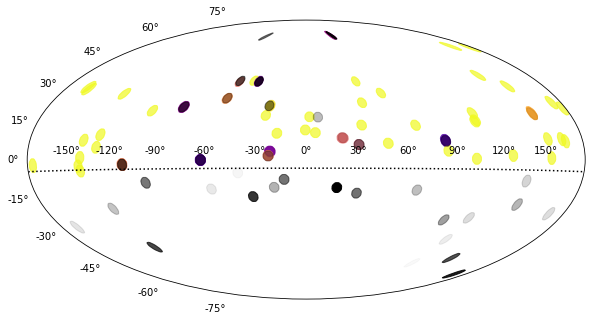

In [103]:
fig = plt.figure()
fig.set_size_inches((10, 8))
ax = fig.add_subplot(111, projection='hammer')

circles = []
for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    circles.append(mpatches.Circle((r-np.pi,d), 0.05, color=color, alpha=0.7))
collection = PatchCollection(circles, match_original=True)    
ax.add_collection(collection)   

circles = []
norm = max([1 - _/zth for _ in redshift])
for r, d, z in zip(s_ra, s_dec, redshift):
    circles.append(mpatches.Circle((r-np.pi,d), 0.05, color='k', alpha=(1-z/zth)/norm))
collection = PatchCollection(circles, match_original=True)
ax.add_collection(collection)
ax.axhline(np.deg2rad(-5), color='k', linestyle=":")

In [104]:
Esrc

array([3.28204829e+05, 7.57630875e+06, 6.68477339e+05, 3.44566161e+06,
       1.71929405e+07, 1.89267605e+05, 9.91671748e+05, 1.07394979e+08,
       5.02032176e+05, 1.32186130e+06, 8.80507678e+05, 8.31969446e+05,
       4.27091198e+05, 5.10927280e+05, 8.99204343e+05, 3.78610745e+05,
       3.39957272e+05, 1.08995002e+06, 8.98829988e+05, 4.76940197e+05,
       1.13119940e+06, 6.70706703e+05, 3.54114740e+07, 4.39259440e+06,
       3.52054874e+05, 1.58618723e+06, 1.84112455e+06, 1.88870461e+05,
       5.16239013e+05, 8.07692982e+05, 1.00563812e+06, 1.92217069e+06,
       9.57172888e+05, 8.25523464e+06, 2.40899110e+05, 7.72228347e+05,
       1.85012021e+06, 2.06831287e+05, 8.20497758e+05, 3.80431256e+05,
       8.89210062e+06, 2.52018060e+06, 7.09511035e+05, 8.50255196e+05,
       1.83008453e+05, 2.19066330e+05, 3.57377453e+05, 3.77177109e+05,
       3.94874550e+05, 7.86692137e+05, 3.13930864e+05, 1.56032675e+07,
       7.64852141e+05, 4.61505069e+05, 1.20114270e+07, 2.03088887e+05,
      

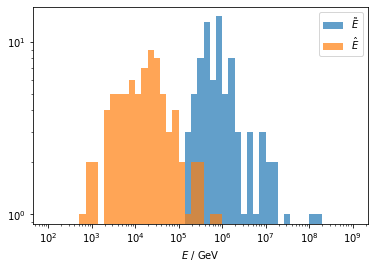

In [105]:
# Plot energies
Emin_cascades = inputs['Emin']
bins = np.logspace(np.log(Emin_cascades/1000), np.log(1E+4*Emin_cascades), base = np.e)

fig, ax = plt.subplots()
ax.hist(Esrc, bins=bins, label='$\\tilde{E}$', alpha=0.7);
ax.hist(Edet_sim, bins=bins, label='$\hat{E}$', alpha=0.7);
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();

## Generate Stan code for fit

In [106]:
from python.backend.stan_generator import ParametersContext, TransformedParametersContext, ModelContext
from python.backend.variable_definitions import ParameterDef, ParameterVectorDef

In [121]:
with StanFileGenerator("stan_files/model_code") as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("energy_spectrum.stan")
        _ = Include("sim_functions.stan")
        ntd = NorthernTracksDetectorModel()
        
    with DataContext() as dc:
        
        # Neutrinos
        N = ForwardVariableDef("N", "int")
        N_str = ["[", N, "]"]
        omega_det = ForwardArrayDef("omega_det", "unit_vector[3]", N_str)
        Edet = ForwardVariableDef("Edet", "vector[N]")
        Emin = ForwardVariableDef("Emin", "real")
        
         # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        D = ForwardVariableDef("D", "vector[Ns]")
        z = ForwardVariableDef("z", "vector[Ns+1]")

        # Precomputed quantities
        Ngrid = ForwardVariableDef("Ngrid", "int")
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardArrayDef("integral_grid", 
                                        "vector[Ngrid]", Ns_1p_str)
        
        # Inputs
        T = ForwardVariableDef("T", "real")
        
    with TransformedDataContext() as tdc:
        
        zenith = ForwardVariableDef("zenith", "vector[N]")
        
        with ForLoopContext(1, N, "i") as i:
            zenith[i] << StringExpression(["pi() - acos(", omega_det[i][3], ")"])
        
        StringExpression(["print(", Ngrid, ")"])
            
    with ParametersContext() as pc:
        
        Q = ParameterDef("Q", "real", 0.0, 1e60)
        F0 = ParameterDef("F0", "real", 0.0, 500)
        
        alpha = ParameterDef("alpha", "real", 1.5, 3.5)
        
        Esrc = ParameterVectorDef("Esrc", "vector", N_str, Emin, 1e8)
        
    with TransformedParametersContext() as tpc:
        
        Fs = ParameterDef("Fs", "real", 0.0)
        
        F = ForwardVariableDef("F", "vector[Ns]")
        allF = ForwardVariableDef("allF", "vector[Ns+1]")
        eps = ForwardVariableDef("eps", "vector[Ns+1]")
        
        f = ParameterDef("f", "real", 0, 1)
        FT = ParameterDef("FT", "real", 0)
        
        lp = ForwardArrayDef("lp", "vector[Ns+1]", N_str)
        logF = ForwardVariableDef("logF", "vector[Ns+1]")
        Nex = ForwardVariableDef("Nex", "real")
        E = ForwardVariableDef("E", "vector[N]")       
        
        Fs << 0
        with ForLoopContext(1, Ns, "k") as k:
            F[k] << StringExpression([Q, "/ (4 * pi() * pow(", 
                                      D[k], " * ", 3.086e22, ", 2))"])
            allF[k] << F[k]
            StringExpression([Fs," += ", F[k]])
        StringExpression("allF[Ns+1]") << F0
        FT << F0 + Fs
        f << StringExpression([Fs, " / ", FT]) 
        
        logF << StringExpression(["log(", allF, ")"])
        
        with ForLoopContext(1, N, "i") as i:
            lp[i] << logF 
            StringExpression(["print(\"lp[i]: \",", lp[i], ")"])
            with ForLoopContext(1, "Ns+1", "k") as k:
                StringExpression([lp[i][k], " += pareto_lpdf(", Esrc[i], 
                                  " | ", Emin, " , ", alpha-1, ")"])
                E[i] << StringExpression([Esrc[i], " / (",  1+z[k], ")"]) 
                
                StringExpression(["if (", k ," < Ns+1) {\n", 
                                  lp[i][k], " += log(", 
                                  ntd.angular_resolution(E[i], varpi[k], omega_det[i]),
                                  ");\n}\n", "else if (", k, " == Ns+1) {\n", 
                                  lp[i][k], " += ", np.log(1/(4*np.pi)), 
                                  ";\n}"])
                
                StringExpression([lp[i][k], " += log(", 
                                  ntd.energy_resolution(E[i], Edet[i]), ")"])
                
        eps << StringExpression(["get_exposure_factor(", T, ", ", Emin, ", ", 
                                 alpha, ", ", alpha_grid, ", ", 
                                 integral_grid, ", ", Ns, ")"])  
        Nex << StringExpression(["get_Nex(", allF, ", ", eps, ")"])
    
    with ModelContext() as mc:
        
        with ForLoopContext(1, N, "i") as i:
            StringExpression(["target += log_sum_exp(", lp[i], ")"])
        StringExpression(["target += -", Nex])
        
    model = cg.generate_single_file()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11acc0490> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11acc0510> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11acc0410> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11cae0a10> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11e79fd50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11acc0b50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11acdb5d0> already on stack
INFO:python.backend.code_gener

In [122]:
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, 
                              "../dev/statistical_model/4_tracks_and_cascades/stan/")]

sm = stan_utility.compile_model(filename=cg.filename, include_paths=include_paths, 
                                model_name="model")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL model_9dfb58423dd3d51af4fd6f5beff1dd67 NOW.


In [123]:
inputs = {}
inputs["N"] = len(Edet_sim)
inputs["omega_det"] = event.unit_vector
inputs["Edet"] = Edet_sim
inputs["Ns"] = source_list.N - 1

inputs['z'] = redshift
inputs['D'] = lum_dist[:-1]
inputs['varpi'] = varpi_in

inputs["Emin"] = 1e5 # GeV

inputs['Ngrid'] = len(exposure_integral.alpha_grid)
inputs['alpha_grid'] = exposure_integral.alpha_grid
inputs['integral_grid'] = exposure_integral.integral_grid

inputs["T"] = 1

In [ ]:
# fit
fit = sm.sampling(data=inputs, iter=1000, chains=4)

In [58]:
np.logspace(2, 9, n)

array([1.00000000e+02, 5.62341325e+03, 3.16227766e+05, 1.77827941e+07,
       1.00000000e+09])

In [59]:
Edet_sim

array([3.49571646, 4.33024616, 4.90004284, 3.76900298, 4.30696786,
       4.04945775, 5.04154114, 4.10298216, 5.10301597, 4.35026815,
       4.63648445, 4.75127085, 4.83211712, 3.90954469, 3.74656023,
       4.2526149 , 3.64143653, 3.61201149, 3.87720403, 5.4358007 ,
       3.42471812, 3.47892618, 4.76813784, 3.03029111, 3.29538437,
       3.13077049, 5.08114334, 3.95655227, 4.82620164, 4.65802393,
       3.89168358, 5.67274361, 4.0160673 , 4.41801799, 3.20870193,
       4.97750158, 3.94190382, 5.21937516, 4.55482781, 3.57416784,
       5.56019797, 3.9554862 , 4.05472271, 3.73906463, 3.96158302,
       5.21158833, 4.38977561, 4.31862291, 4.8307756 , 4.2184027 ,
       3.81322002, 3.67398267, 4.64869669, 4.34477113, 4.61096975,
       4.69136678, 3.72379367, 2.82693675, 5.22883988, 4.90255972,
       3.40441273, 3.57674614, 4.62183559, 5.25735496, 3.33140384,
       4.047144  , 5.34683466, 3.61697855, 4.91947412, 4.86849595,
       4.24835614, 4.16215812, 6.48507499, 3.70829993, 4.25572